# Main

In [ ]:
import os
import json
import time
import numpy as np
from PIL import Image
import torch
from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if not os.path.exists('/content/clip-video-embedder'):
    !git clone -b dev https://github.com/abreza/clip-video-embedder.git
    %cd /content/clip-video-embedder
    !pip install -r requirements.txt
    clear_output()

else:
  print('Already has cloned!')

%cd /content/clip-video-embedder

from utils.video_loader import download_video_from_youtube, choice_video
from utils.pallet import plot_text_image_pallet, plot_image_image_pallet
from utils.utils import trim_sentences, write_results_to_json, plot_clip_similarities
from dataloaders.rawvideo_util import RawVideoExtractor

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'clip-vit-base-patch16' #'clip-vit-base-patch16', 'clip-vit-large-patch14','blip'

if 'clip' in model_name:

    from transformers import CLIPProcessor, CLIPModel

    model = CLIPModel.from_pretrained(f"openai/{model_name}").to(device).eval()
    processor = CLIPProcessor.from_pretrained(f"openai/{model_name}")

else:
    from transformers import BlipProcessor, BlipModel
    model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device).eval()
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")


## Plot the description-frame similrities of CLIP

In [27]:
def inference(model, preprocess, sentences : list, preprocessed_images : list):
    image_inputs = torch.squeeze(torch.tensor(np.stack(preprocessed_images)), dim=1).to(device)

    text_inputs = processor(text=sentences, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(image_inputs).float()
        text_features = model.get_text_features(**text_inputs).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)
    
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity

In [36]:
def video_analysis(data, length, random_sentences = None, framerate=1,  video_id = None):

    video_id = choice_video(data, length)
    duration = data[video_id]["duration"]
    sentences = data[video_id]["sentences"]
    timestamps = data[video_id]["timestamps"]

    video_path = download_video_from_youtube(video_id[2:], f'./videos/',use_oauth=True)
    
    print(f'ID: {video_id} | Duration:{duration:3.2f} sec | #sent:{len(sentences):2d} | fps:{framerate:2d}',end='')

    tic = time.time()
    video_extractor = RawVideoExtractor(framerate=framerate)
    images = video_extractor.get_video_data(video_path)
    print(f' | Frame extraction: {time.time()-tic :2.2f} sec',end='')

    tic = time.time()
    all_sentences = [' '.join(sentences)] + sentences
    all_sentences = all_sentences + random_sentences if random_sentences else all_sentences
    all_sentences = trim_sentences(all_sentences)

    similarity = inference(model, processor, all_sentences, images)
    print(f' | CLIP inference ({device}): {time.time()-tic :2.2f} sec')
    print('-'*100)
    
    return similarity, video_id

In [30]:
with open('datasets/ActivityNet/train.json') as f:
  data = json.load(f)

Download complete.
ID: v_GHOCVoZsFHE | Duration:116.31 sec | #sent: 2 | fps: 1 | Frame extraction: 13.43 sec | CLIP inference (cuda): 7.84 sec
--------------------------------------------------
Description  1: A man is seen speaking to the camera an leads into clips of him demonstrating martial arts with another man.
Description  2:  The men continue to demonstrate with one another while pausing to speak to the camera.
Description  1: A man is seen speaking to the camera an leads into clips of him demonstrating martial arts with another man.
Description  2:  The men continue to demonstrate with one another while pausing to speak to the camera.


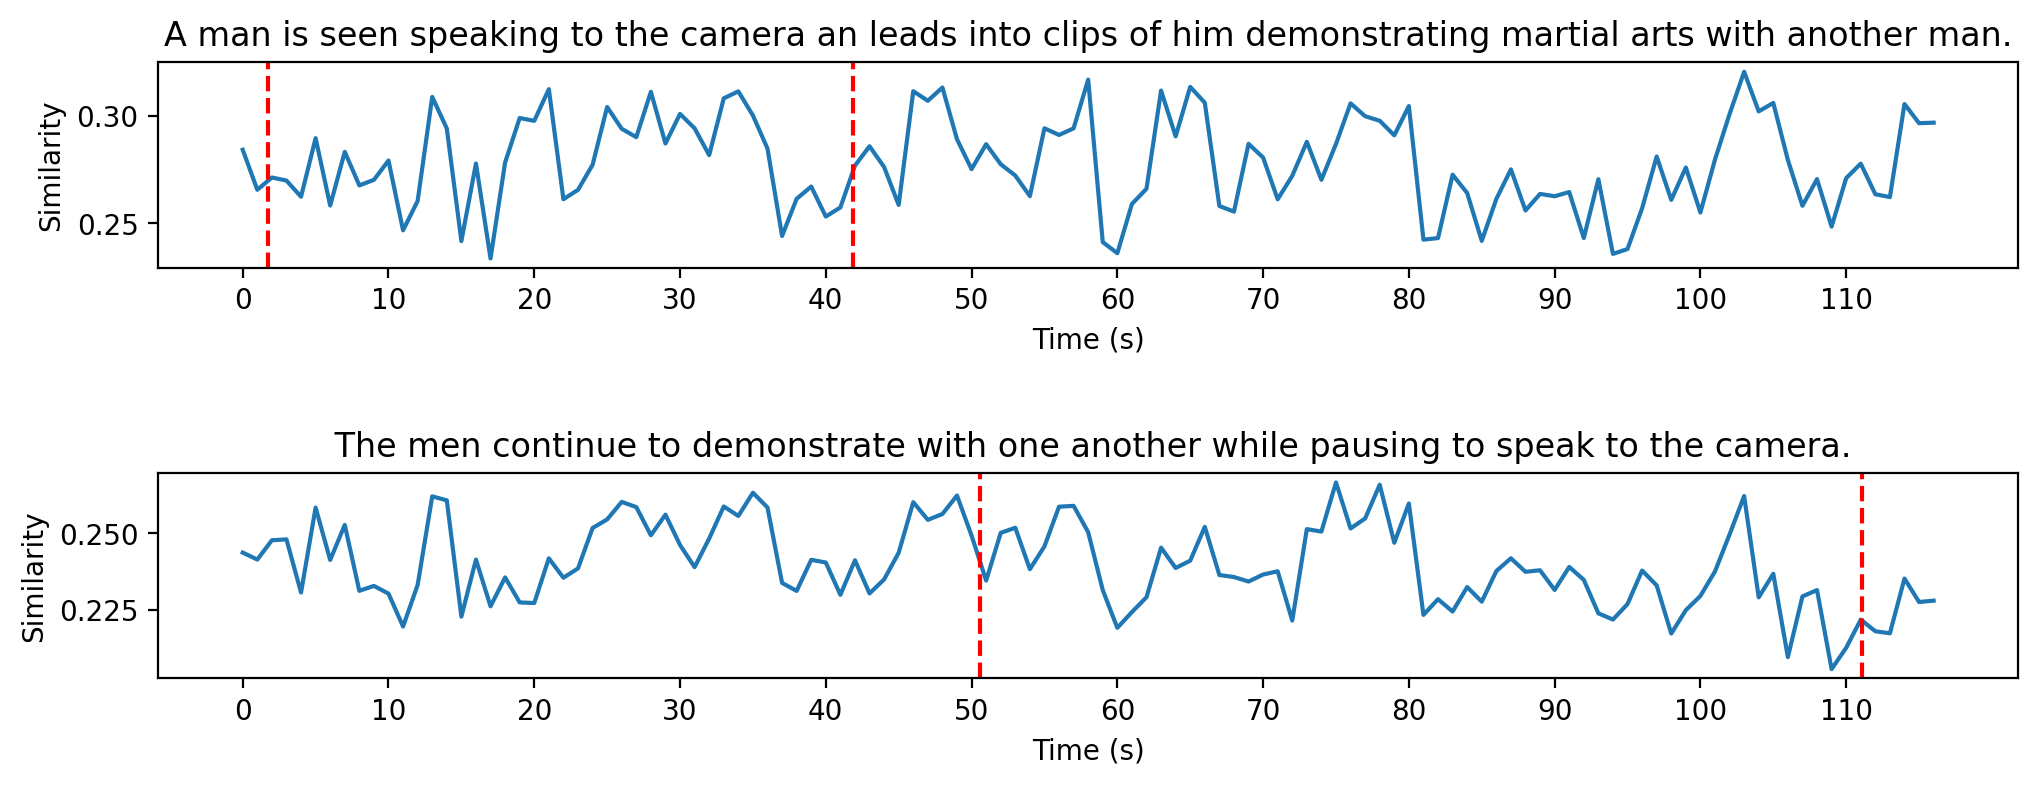


URL: https://www.youtube.com/watch?v=GHOCVoZsFHE


In [34]:
random_sentences = None
framerate = 1

torch.cuda.empty_cache()

similarity_scores, video_id = video_analysis(data, length=100, random_sentences = random_sentences, framerate = framerate)

setting = {
           'force_separate_subplots' : True, #Disables all of the followings if be True
          #  'show_random_plots': True,
           'show_concate_descriptions_plot': True,
          #  'show_average_plot':True,
           'show_max_plot': True,
          #  'show_each_plot': True,
           }

sentences = data[video_id]["sentences"]
timestamps = data[video_id]["timestamps"]

for i, sentence in enumerate(sentences):
    print(f"Description {i+1:2d}: {sentence}")


plot_clip_similarities(similarity_scores, sentences, random_sentences, timestamps, framerate=framerate, **setting)

print(f'URL: https://www.youtube.com/watch?v={video_id[2:]}')

In [41]:
# Save data to a json file to load on https://clip-result.vercel.app

key_names = ['concat'] + [f'Description {i+1}' for i in range(len(sentences))] 
key_names = key_names + [f'Random Description {i+1}' for i in range(len(random_sentences))] if random_sentences else key_names

descriptions = ['cancate of descriptions'] + sentences
descriptions = descriptions + random_sentences if random_sentences else descriptions
output_file = f'/content/{video_id}.json'

write_results_to_json(key_names, descriptions, similarity_scores, timestamps, output_file)

## Plot test pallets

Some weights of the model checkpoint at Salesforce/blip-image-captioning-base were not used when initializing BlipModel: ['text_decoder.bert.encoder.layer.7.output.dense.weight', 'text_decoder.bert.encoder.layer.4.intermediate.dense.bias', 'text_decoder.bert.encoder.layer.3.attention.self.value.bias', 'text_decoder.bert.encoder.layer.2.crossattention.output.dense.bias', 'text_decoder.bert.encoder.layer.4.attention.self.value.weight', 'text_decoder.bert.encoder.layer.9.intermediate.dense.bias', 'text_decoder.bert.encoder.layer.1.attention.output.LayerNorm.bias', 'text_decoder.bert.encoder.layer.10.intermediate.dense.weight', 'text_decoder.bert.encoder.layer.8.attention.self.query.bias', 'text_decoder.bert.encoder.layer.3.attention.output.dense.weight', 'text_decoder.bert.encoder.layer.5.crossattention.self.key.bias', 'text_decoder.bert.encoder.layer.10.crossattention.output.LayerNorm.bias', 'text_decoder.bert.encoder.layer.10.intermediate.dense.bias', 'text_decoder.bert.encoder.layer.7.

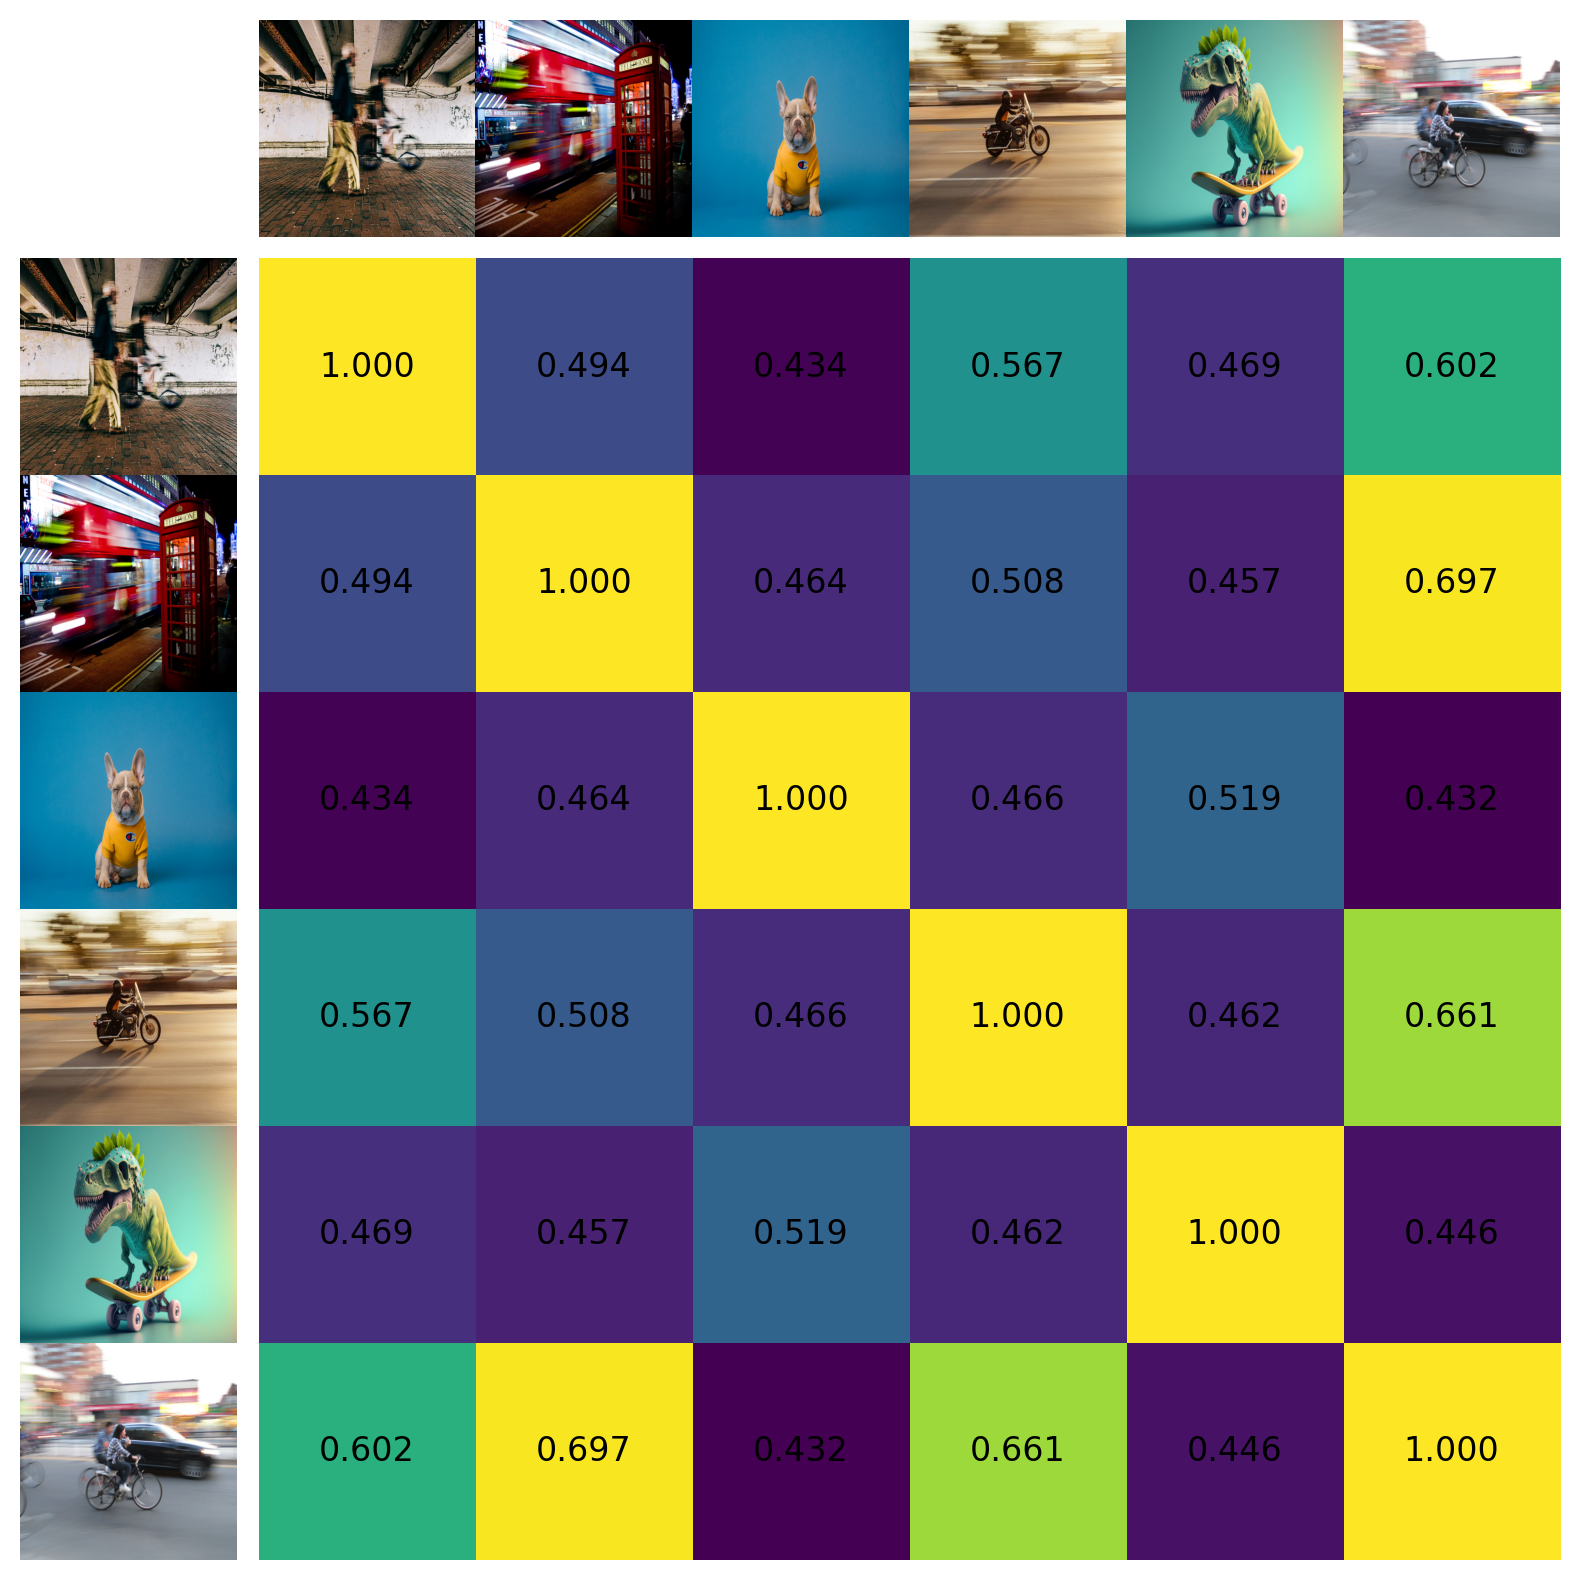

In [ ]:
folder_path = '/content/images'   
images = []

for filename in os.listdir(folder_path):
  if filename.endswith('.jpg') or filename.endswith('.webp') or filename.endswith('.png'):
    image_path = os.path.join(folder_path, filename)
    image = Image.open(image_path)
    images.append(image)

if images == []:
  colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
  # color_names = ['red','green','blue','yellow','light blue']

  for color in colors:
    image = Image.new('RGB', (224, 224), color)
    images.append(image)
    
plot_text_image_pallet(model, processor, images, sentences=['motion','blur'])

plot_image_image_pallet(model, processor, images)

## Some usefull modules


In [ ]:
import math
def compute_size(tensor_shape):
    size = math.prod(tensor_shape) * 4 / 1024/1024

    if size/1024 <1:
      print(f"Size: {size:.2f} MB")
    else:
      print(f"Size: {size/1024:.2f} GB")

In [ ]:
compute_size((224,224,3,60*10,30))

Size: 10.09 GB


In [ ]:
import dataloaders.rawvideo_util as df

import importlib
importlib.reload(df)

from dataloaders.rawvideo_util import RawVideoExtractor